In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras as ks
import seaborn as sns
from PIL import Image
%matplotlib inline

In [70]:
# input the names of folder containing the data  
files = "Zurich_Files"

# Training the model

Those steps are detailed inthe rest of the repository

## Survey Answers and Image Ranking

In [71]:
surv = pd.read_csv('../Data/Survey/CleanedResults.csv')
surv = surv.iloc[: , 1:] #Just to remove this Unnamed 0 column

In [72]:
win = pd.DataFrame(surv['Winner'].value_counts())
win.sort_index(ascending=True, inplace=True)

In [73]:
im1 = pd.DataFrame(surv['Image1 ID'].value_counts())
im1.sort_index(ascending=True, inplace=True)

In [74]:
im2 = pd.DataFrame(surv['Image2 ID'].value_counts())
im2.sort_index(ascending=True, inplace=True)

In [75]:
occur = pd.DataFrame(im1.values+im2.values, columns=['Image occurence'])

In [76]:
contest = pd.concat([occur, win],axis=1)

In [77]:
contest['Win ratio'] = contest['Winner'] / contest['Image occurence']

In [78]:
contest.reset_index(inplace=True)
contest.fillna(0.0, inplace=True)

In [79]:
contest.drop(['Image occurence','Winner'], axis=1, inplace=True)

## Feature engineering

Do feature engineering, feature expansion, standardize numerical data, one_hot_encode vehicles and other objects, etc.

### Building the dataframe

In [80]:
pd.set_option('display.max_rows', None)

### Final training dataframe

In [81]:
obj_rgb_bright = pd.read_csv('Training_Files/images_features.csv')
df_model = pd.merge(contest, obj_rgb_bright, left_on='index', right_on='Image number', how='outer')
obj_num = df_model['Image number'].value_counts()
obj_num.sort_index(ascending=True, inplace=True)
obj_num = np.array(obj_num)
obj_num = pd.DataFrame(obj_num, columns=['Number of obj.'])
size = df_model[['Image number','Size of box']].groupby('Image number').sum()
size = size / 360000
df_model.drop(['Object','Reliability','Size of box'], axis=1, inplace=True)
df_model = pd.merge(df_model, size, on='Image number', how='outer')
df_model = df_model.groupby('Image number').mean()


In [82]:
df_model_final = pd.read_csv('Training_Files/Segmented_features.csv')
# df_model_final.describe()

In [83]:
df_model_final['Size of box'] = df_model['Size of box']
df_model_final['Win ratio'] = contest['Win ratio']
df_model_final = df_model_final.iloc[: , 1:] #Just to remove this Unnamed 0 column

## Build a Model

In [84]:
import os
import math
import random
import itertools

import numpy as np    
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns
sns.set(style="white")

from math import log

from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LinearRegression
from sklearn.linear_model    import LogisticRegression
from sklearn.linear_model    import Lasso
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.svm             import SVC
from sklearn.svm             import SVR
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier

from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import mean_squared_error
from sklearn.metrics         import r2_score
from sklearn.metrics         import classification_report

from sklearn.pipeline        import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore') # ignore some warnings 

SEED = 123456789   # Define a random seed so random steps can be replicated.  

In [85]:
# df_model_final = df_model_final[:457]
df_model_final = df_model_final.dropna()

In [86]:
# Select target variable into an ARRAY called `y` and features into a DATAFRAME called  `X` 
y = np.array(df_model_final['Win ratio'])
features = list(set(list(df_model_final.columns)) - set(['Win ratio']))
X = df_model_final.loc[:, features]

In [87]:
# Divide data into a training set and a testing set using the train_test_split() function
#   NOTE: Please call the subsamples `X_train` ,  `X_test` , `y_train` , `y_test` so we can follow your code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)

In [88]:
def rss(y, y_hat):
    return sum( [ (yi - yi_hat)**2  for yi, yi_hat in zip(y, y_hat)] )

def mse(y, y_hat, p=0):
    return math.sqrt( (rss(y, y_hat))/ (len(y)-p-1) )

## Projecting in 2D (PCA)

In [89]:
from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import PolynomialFeatures
from sklearn.decomposition   import PCA

In [90]:
# Select target variable into an ARRAY called `y` and features into a DATAFRAME called  `X` 
y = np.array(df_model_final['Win ratio'])
features = list(set(list(df_model_final.columns)) - set(['Win ratio']))
X = df_model_final.loc[:, features]
#X

In [91]:
scaler = StandardScaler()
X_stand = scaler.fit_transform(X)

pca2 = PCA(n_components=2)
pca2.fit(X_stand)
X_proj = pca2.transform(X_stand)

## SVR

In [92]:
c_opt = 0.1 # MSE is 0.1396

In [93]:
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell pipeline to standardize features
estimators.append(('svm_model', SVR()))  # tell pipeline to use an SVR model with lasso
pipeline_svr = Pipeline(estimators) 
pipeline_svr.get_params()

{'memory': None,
 'steps': [('standardize', StandardScaler()), ('svm_model', SVR())],
 'verbose': False,
 'standardize': StandardScaler(),
 'svm_model': SVR(),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'svm_model__C': 1.0,
 'svm_model__cache_size': 200,
 'svm_model__coef0': 0.0,
 'svm_model__degree': 3,
 'svm_model__epsilon': 0.1,
 'svm_model__gamma': 'scale',
 'svm_model__kernel': 'rbf',
 'svm_model__max_iter': -1,
 'svm_model__shrinking': True,
 'svm_model__tol': 0.001,
 'svm_model__verbose': False}

In [94]:
pipeline_svr.set_params(svm_model__C = c_opt)
pipeline_svr.fit(X_train, y_train)
y_pred_svr = pipeline_svr.predict(X_test)
print("Testing MSE (SVR):", round(mse(y_test, y_pred_svr), 4))

Testing MSE (SVR): 0.1345


In [95]:
svr_results = {'Predicted_val': y_pred_svr, 'Real_val': y_test}
svr_results = pd.DataFrame(svr_results)
# svr_results

### Dataset classes

In [96]:
df_model_final['class'] = 0
nclasses = 5

In [97]:
# Transform into classes 1 to nclasses
step = 1/nclasses
print(step)
for i in range(nclasses):
    inf = float("{:.4f}".format(i*step))
    sup = float("{:.4f}".format((i+1)*step))
    print(inf,sup)
    if (sup < 1):
        df_model_final['class'][(df_model_final['Win ratio'] >= inf) & (df_model_final['Win ratio'] < sup)] = i+1
    else :
        df_model_final['class'][(df_model_final['Win ratio'] >= inf)] = i+1    


0.2
0.0 0.2
0.2 0.4
0.4 0.6
0.6 0.8
0.8 1.0


In [98]:
df_model_final = df_model_final.drop('Win ratio', axis=1)

In [99]:
df_model_final['class'].value_counts()

3    160
4    131
2    109
1     32
5     26
Name: class, dtype: int64

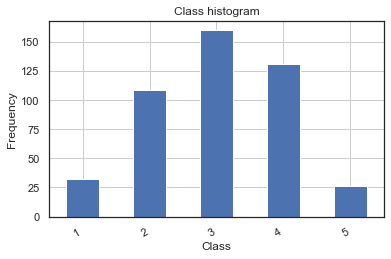

In [100]:
stars = pd.Series((1, 2, 3, 4, 5, 6))
vc = df_model_final['class'].value_counts().sort_index()
ax = vc.plot(kind='bar')
fig = ax.get_figure()
fig.autofmt_xdate()
plt.title('Class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [101]:
# Select target variable into an ARRAY called `y` and features into a DATAFRAME called  `X` 
y = np.array(df_model_final['class'])
features = list(set(list(df_model_final.columns)) - set(['class']))
X = df_model_final.loc[:, features]

In [102]:
# Divide data into a training set and a testing set using the train_test_split() function
#   NOTE: Please call the subsamples `X_train` ,  `X_test` , `y_train` , `y_test` so we can follow your code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
X_train.describe()
X_test.describe()

,Green,White,Black,Blue,Size of box,Grey
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,34055.543478,15615.086957,15182.684783,29375.173913,0.052494,210118.706522
std,15464.789909,10641.241345,10231.984429,24974.591782,0.058041,37646.321917
min,7917.000000,1466.000000,1811.000000,949.000000,0.000000,124555.000000
25%,22580.750000,8630.000000,8336.250000,5444.250000,0.005040,191110.500000
50%,32842.500000,12896.500000,12449.500000,22906.500000,0.026906,215614.000000
75%,43953.500000,18987.750000,19293.750000,51461.750000,0.087131,231786.000000
max,70759.000000,67433.000000,54796.000000,89487.000000,0.207269,282956.000000


### Logit model


In [103]:
from numpy import argmax
from sklearn.preprocessing   import StandardScaler
from tensorflow.keras.utils import to_categorical

In [104]:
def logit_CV(x_train, y_train, c_range):
    splits_num = 5

    AUC = np.zeros((splits_num, len(c_range)))

    for i in range(len(c_range)):

        kf = KFold(n_splits=splits_num)

        k = 0
        for learn_index, val_index in kf.split(x_train):
            x_train_train, x_train_val = x_train[learn_index], x_train[val_index]
            y_train_train, y_train_val = y_train[learn_index], y_train[val_index]

            pipeline_logit.set_params(logit_model_l1__C = c_range[i])

            pipeline_logit.fit(x_train_train, y_train_train)

            y_pred_logit_proba = pipeline_logit.predict(x_train_val)
            
            encoded_y_train_val = to_categorical(y_train_val, num_classes=nclasses + 1)
            encoded_y_pred_logit_proba = to_categorical(y_pred_logit_proba, num_classes=nclasses + 1)

            AUC[k, i] = round(roc_auc_score(encoded_y_train_val[:,1:], encoded_y_pred_logit_proba[:,1:],
                                            multi_class="ovr", average='micro'), 4)

            k = k+1

    auc_mean = np.zeros(len(c_range))
    auc_std = np.zeros(len(c_range))
    for i in range(len(c_range)):
        auc_mean[i] = AUC[:, i].mean()
        auc_std[i] = AUC[:, i].std()
        
    return auc_mean, auc_std

In [105]:
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell pipeline to standardize features
estimators.append(('logit_model_l1', LogisticRegression(penalty = "l1", solver = "saga", random_state = SEED)))  # tell pipeline to use a logit model with lasso
pipeline_logit = Pipeline(estimators) 
pipeline_logit.get_params()

{'memory': None,
 'steps': [('standardize', StandardScaler()),
  ('logit_model_l1',
   LogisticRegression(penalty='l1', random_state=123456789, solver='saga'))],
 'verbose': False,
 'standardize': StandardScaler(),
 'logit_model_l1': LogisticRegression(penalty='l1', random_state=123456789, solver='saga'),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'logit_model_l1__C': 1.0,
 'logit_model_l1__class_weight': None,
 'logit_model_l1__dual': False,
 'logit_model_l1__fit_intercept': True,
 'logit_model_l1__intercept_scaling': 1,
 'logit_model_l1__l1_ratio': None,
 'logit_model_l1__max_iter': 100,
 'logit_model_l1__multi_class': 'auto',
 'logit_model_l1__n_jobs': None,
 'logit_model_l1__penalty': 'l1',
 'logit_model_l1__random_state': 123456789,
 'logit_model_l1__solver': 'saga',
 'logit_model_l1__tol': 0.0001,
 'logit_model_l1__verbose': 0,
 'logit_model_l1__warm_start': False}

In [106]:
c_logit_class=0.12
pipeline_logit.set_params(logit_model_l1__C = c_logit_class)
pipeline_logit.fit(X_train, y_train)
y_pred_logit_proba = pipeline_logit.predict(X_test)
encoded_y_test = to_categorical(y_test, num_classes=nclasses + 1)
encoded_y_pred_logit_proba = to_categorical(y_pred_logit_proba, num_classes=nclasses + 1)
print("Test AUC (logit):", roc_auc_score(encoded_y_test[:,1:], encoded_y_pred_logit_proba[:,1:],
                                         multi_class="ovr", average='micro'))    
                                    

Test AUC (logit): 0.7758152173913043


# Process new images

## Segmentation

In [107]:
from scipy.spatial import distance_matrix
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [108]:
#Setup cluster centers for segmentation
cluster_centers=[]
cluster_centers.append([0,0,0])         #black

cluster_centers.append([70,70,70])      #dark grey
cluster_centers.append([125,125,125])   #grey
cluster_centers.append([180,180,180])   #light grey

cluster_centers.append([255,255,255])   #white

cluster_centers.append([50,70,0])       #dark green
cluster_centers.append([160,160,90])    #light green

cluster_centers.append([90,120,145])    #dark blue
cluster_centers.append([130,160,190])   #light blue

cluster_centers.append([100,40,30])      #dark red
cluster_centers.append([210,100,90])     #red
cluster_centers.append([120,110,100])    #orange/brown

cluster_centers=np.array(cluster_centers)    

rows = 600
cols = 600

def open_image(nb):
    #Open original image
    image_path = "Extrapolation/" + str(nb) + ".jpg"
    original_image = Image.open(image_path)

    #Flatten the image
    flattened_image = np.array(original_image)
    flattened_image = flattened_image.reshape(rows*cols, 3)
    return original_image, flattened_image

def segment_images(nb_images):
    #Prepare the output, which is a matrix whose lines correspond to each image, and columns to the pixels. The value is the label of the class this pixel in this image belongs to.
    images_labels = np.zeros((nb_images,rows*cols))

    for i in range(nb_images):

        #Open the image
        original_image, flattened_image = open_image(i)

        #Assign the labels based on the distance to the cluster centers.
        dist_mat = distance_matrix(flattened_image, cluster_centers)
        assignments = np.argmin(dist_mat, axis=1)

        #Replace each pixel value with its nearby centroid
        segmented_image = cluster_centers[assignments]
        images_labels[i] = assignments
        segmented_image = np.clip(segmented_image.astype('uint8'), 0, 255)

        #Reshape the image to original dimension
        segmented_image = segmented_image.reshape(rows, cols, 3)

        # #Save the segmented image in the folder
        # output_path = "SegmentedNewImages/" + str(i) + ".jpg"
        # im = Image.fromarray(segmented_image)
        # im.save(output_path)

        #Print a result every 20 steps
        if(i % 100 == 0):
            print("Image " + str(i))
            fig = plt.figure()

            #Visualize segmented images against original

            ax1 = fig.add_subplot(1, 2, 1)
            ax1.imshow(original_image, cmap='Greys_r')
            ax2 = fig.add_subplot(1, 2, 2)
            ax2.imshow(segmented_image, cmap='Greys_r')
            plt.tight_layout()
            plt.show()

    return images_labels

#Get color classes from segmentation by counting number of pixels in each of the (nb_clusters) classes
def get_info_images_labels(images_labels):
    features = np.zeros((images_labels.shape[0], cluster_centers.shape[0]))

    for n in range(images_labels.shape[0]):

        labels = images_labels[n]
        for k in range(cluster_centers.shape[0]):
            features[n,k] = np.count_nonzero(labels == k)       
        
    return features    


## Segmented features

In [109]:
x_test = pd.read_csv(files+ '/Color_features.csv')

## Object detection 

In [111]:
objects = pd.read_csv(files+'/Object_features.csv')
size = objects[['Image number','Size of box']].groupby('Image number').sum()
size = size / 360000
objects.drop(['Object','Reliability','Size of box'], axis=1, inplace=True)
objects = pd.merge(objects, size, on='Image number', how='outer')
objects = objects.groupby('Image number').mean()
objects.describe()

,Unnamed: 0,Size of box
count,918.000000,918.000000
mean,2293.069717,0.068041
std,1245.859703,0.077685
min,2.500000,0.000144
25%,1248.500000,0.011619
50%,2351.000000,0.037712
75%,3356.875000,0.103484
max,4362.000000,0.635542


## Gather all image features in a dataset

In [112]:
x_test['Size of box'] = objects['Size of box']
x_test = x_test.iloc[: , 1:] #Just to remove this Unnamed 0 column
x_test.describe()
x_test_final=pd.DataFrame()
cols = X_test.columns
for c in cols:
    x_test_final[c] = x_test[c]

x_test_final.describe()    

,Green,White,Black,Blue,Size of box,Grey
count,1010.000000,1010.000000,1010.000000,1010.000000,918.000000,1010.000000
mean,26532.427723,15914.737624,12364.089109,17638.124752,0.068041,211405.396040
std,16909.015872,11676.280030,9525.814068,20132.608114,0.077685,40729.201392
min,1981.000000,163.000000,335.000000,15.000000,0.000144,99975.000000
25%,13911.000000,6933.500000,6031.000000,4166.500000,0.011619,183823.750000
50%,22388.500000,14050.500000,10032.000000,10220.500000,0.037712,211766.500000
75%,35501.500000,22454.750000,15536.250000,22512.000000,0.103484,240153.500000
max,154601.000000,85078.000000,72845.000000,120511.000000,0.635542,331177.000000


# Generate predictions for the images

In [113]:
# predictions = pipeline_logit.predict(x_test_final.fillna(0))
# encoded_predictions = to_categorical(predictions, num_classes=nclasses + 1)

In [115]:
predictions = pipeline_svr.predict(x_test_final.fillna(0))

In [116]:
predictions

array([0.45007289, 0.44143809, 0.45656381, ..., 0.39843955, 0.36153474,
       0.32585224])

In [117]:
pd.DataFrame(predictions).to_csv(files+'/predictions')